In [1]:
#requirements
#pip3 install pandas numpy seaborn matplotlib

In [2]:
import pandas as pd
from datetime import datetime
from matplotlib import pyplot
from pylab import rcParams
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('../data/datasets/onemonthprocessed_nodeload15.csv')
df.set_index(pd.to_datetime(df.ds), drop=True, inplace=True)
df.drop('ds', axis=1, inplace=True)
#df['ds'] = pd.to_datetime(df['ds'], dayfirst=True)
#df = df.drop_duplicates(subset=['ds'], keep='first')
print(df.head(5))
print(df.tail(5))
print(df.describe())
print(df.dtypes)
print(len(df['y']))

                        y
ds                       
2024-05-13 00:00:00  6.53
2024-05-13 00:00:05  6.53
2024-05-13 00:00:10  6.53
2024-05-13 00:00:15  6.52
2024-05-13 00:00:20  6.52
                       y
ds                      
2024-06-13 23:59:40  2.6
2024-06-13 23:59:45  2.6
2024-06-13 23:59:50  2.6
2024-06-13 23:59:55  2.6
2024-06-14 00:00:00  2.6
                   y
count  532711.000000
mean        4.380956
std         2.186642
min         1.090000
25%         2.230000
50%         4.730000
75%         6.060000
max        10.500000
y    float64
dtype: object
532711


/var/folders/bq/b47vvv5n2kxgsnrpx8jqvtqm0000gn/T/ipykernel_1052/191874907.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df.set_index(pd.to_datetime(df.ds), drop=True, inplace=True)


In [4]:
#Let’s check that if the given dataset is stationary or not, For that we use adfuller.
#from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['y'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -4.461985108975942
p-value: 0.00023019446983449013


Test Statistic                     -4.461985
p-value                             0.000230
#Lags Used                         86.000000
Number of Observations Used    532624.000000
Critical Value (1%)                -3.430362
Critical Value (5%)                -2.861545
Critical Value (10%)               -2.566773
dtype: float64


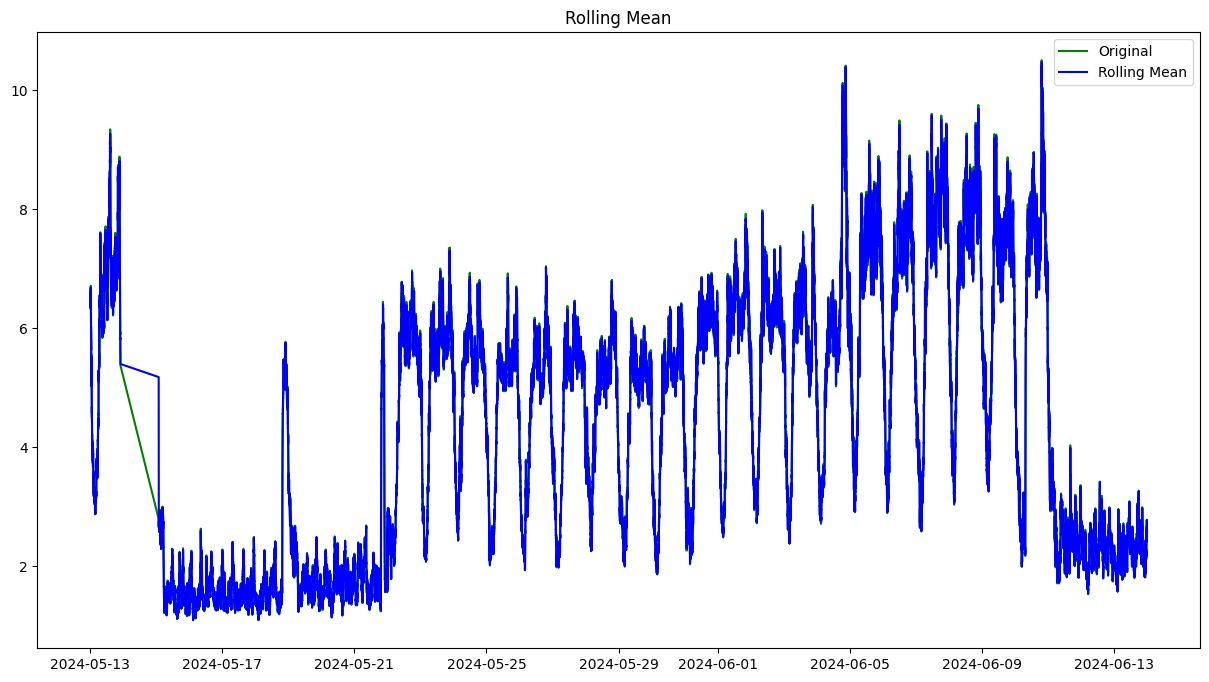

In [5]:
result_output = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
#print("df_output: \n",result_output)
for key,value in result[4].items():
    result_output['Critical Value (%s)'%key] = value
print(result_output)

# Calculate the rolling mean
roll_mean = df['y'].rolling(12).mean()

# Plot rolling statistics
plt.figure(figsize=(15, 8))
plt.plot(df['y'], color='green', label='Original')
plt.plot(roll_mean, color='blue', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean')
plt.show()

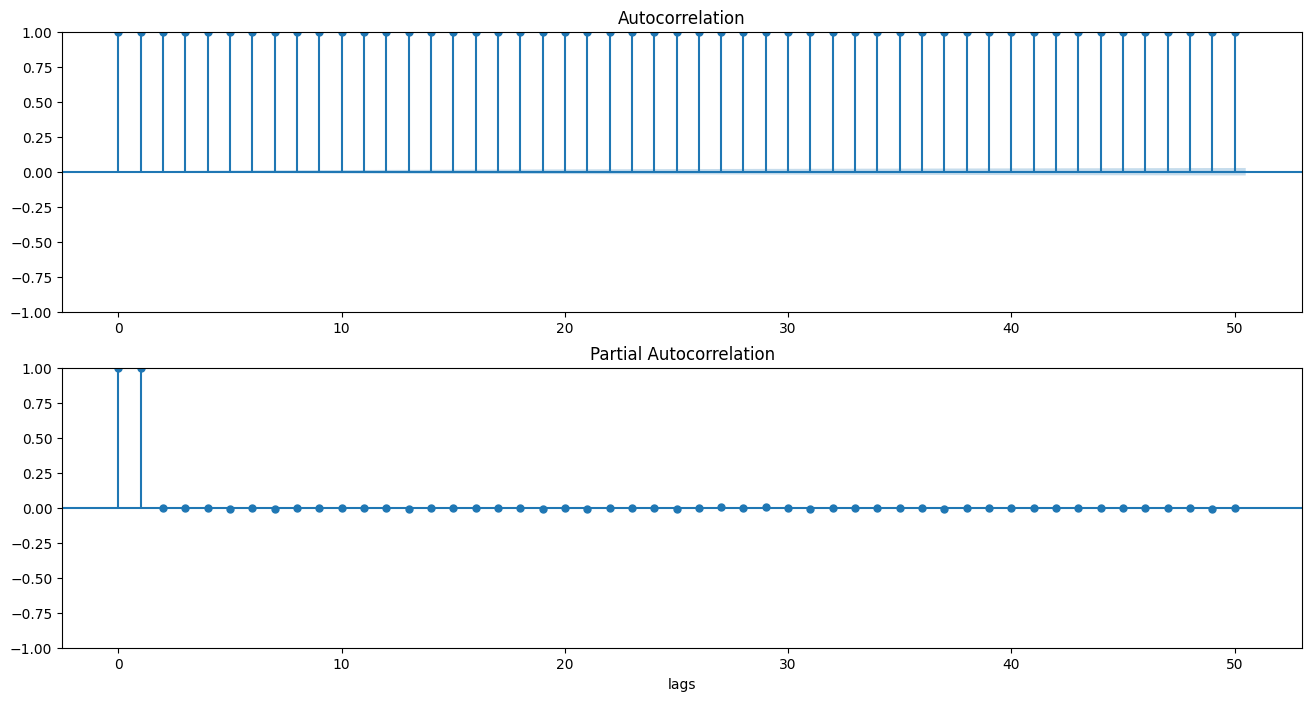

In [6]:
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
plt.figure(figsize=(16, 8))
plt.subplot(211)
plot_acf(df['y'], lags=50, ax=plt.gca())
plt.subplot(212)
plot_pacf(df['y'], lags=50, ax=plt.gca())
plt.xlabel('lags')
plt.show()

**ARIMA**

**Building an ARIMA Model: A Step-by-Step Guide:**
    
    1. Model Definition: Initialize the ARIMA model by invoking ARIMA() and specifying the p, d, and q parameters.
    2. Model Training: Train the model on your dataset using the fit() method.
    3. Making Predictions: Generate forecasts by utilizing the predict() function and designating the desired time index or indices.


In [7]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model (example order)
model = ARIMA(df, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

/Library/Python/3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Python/3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Python/3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:               532711
Model:                 ARIMA(1, 1, 1)   Log Likelihood             1236957.395
Date:                Sun, 14 Jul 2024   AIC                       -2473908.789
Time:                        15:28:28   BIC                       -2473875.232
Sample:                             0   HQIC                      -2473899.315
                             - 532711                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0708      0.006     11.212      0.000       0.058       0.083
ma.L1         -0.0708      0.006    -11.212      0.000      -0.083      -0.058
sigma2         0.0006    7.7e-08   7311.821      0.0

/var/folders/bq/b47vvv5n2kxgsnrpx8jqvtqm0000gn/T/ipykernel_1052/1790419592.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly_data = df.resample('H').mean()


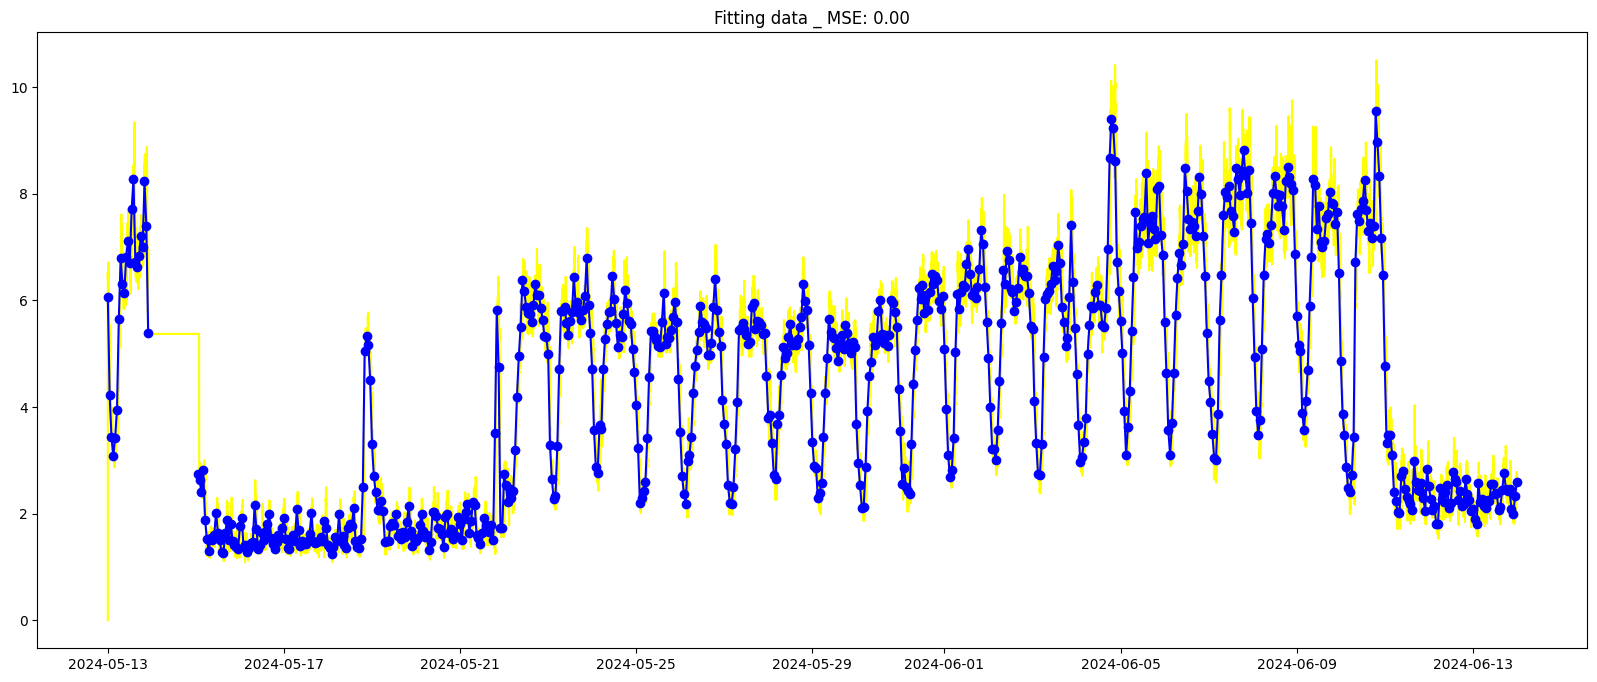

In [8]:
plt.figure(figsize=(20, 8))
#plt.plot(df.y, color='blue',label='Original Data')
plt.plot(model_fit.fittedvalues, color='yellow', label='Fitted Values')
df_hourly_data = df.resample('H').mean()
plt.plot(df_hourly_data.index, df_hourly_data['y'], marker='o', linestyle='-', color='b', label='Hourly Data')
plt.title('Fitting data _ MSE: %.2f'% (((model_fit.fittedvalues-df.y)**2).mean()))
plt.show()

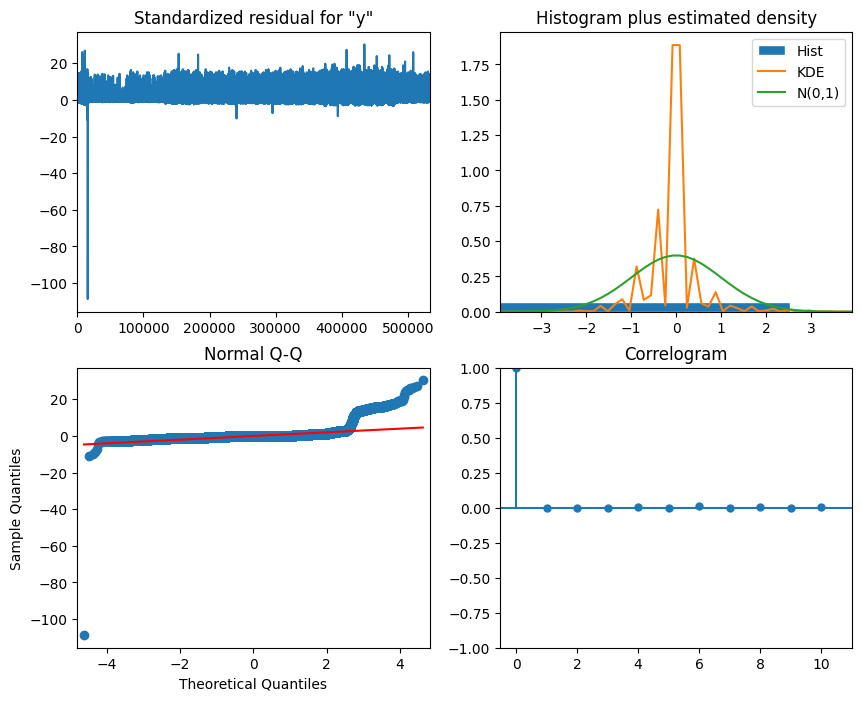

In [9]:
model_fit.plot_diagnostics(figsize=(10, 8))
plt.show()

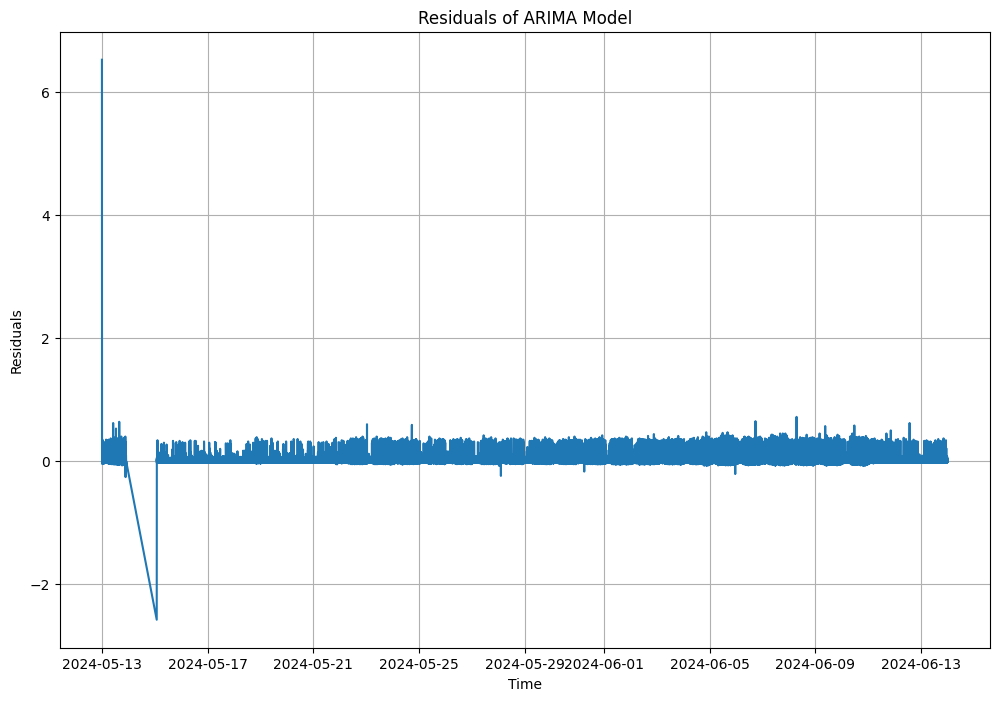

In [10]:
# line plot of residuals
from pandas import DataFrame
residuals = DataFrame(model_fit.resid)
plt.figure(figsize=(12, 8))  # Adjust the figsize as per your preference
plt.plot(residuals, label = 'residuals')
plt.title('Residuals of ARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

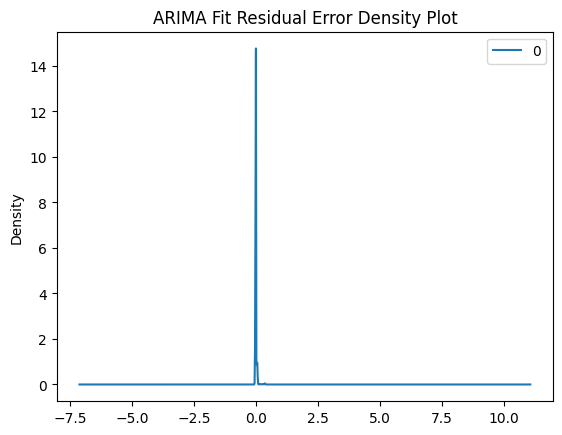

                  0
count  5.327110e+05
mean   4.880732e-06
std    2.536207e-02
min   -2.580000e+00
25%   -2.314990e-07
50%    1.646949e-11
75%    4.685827e-08
max    6.530000e+00


In [11]:
# density plot of residuals
residuals.plot(kind='kde')
plt.title('ARIMA Fit Residual Error Density Plot')
pyplot.show()
print(residuals.describe())
# summary stats of residuals

In [12]:
forecast_steps = 432000 #5days
forecast = model_fit.get_forecast(steps=forecast_steps)
print(forecast)

/Library/Python/3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Python/3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [20]:
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Create date range for the forecast
last_date = df.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(seconds=5), periods=forecast_steps, freq='5s')

# Create DataFrame for predictions
forecast_df = pd.DataFrame({
    'date': forecast_dates,
    'predicted_mean': forecast_mean,
    'lower_ci': forecast_ci.iloc[:, 0],
    'upper_ci': forecast_ci.iloc[:, 1]
})

# Set date as index
forecast_df.to_csv('../data/predicted/arima_month_forecast_nodeload15.csv', index=False)
forecast_df.set_index('date', inplace=True)
print(forecast_df)

                     predicted_mean   lower_ci   upper_ci
date                                                     
2024-06-14 00:00:05             2.6   2.553487   2.646513
2024-06-14 00:00:10             2.6   2.534221   2.665779
2024-06-14 00:00:15             2.6   2.519437   2.680563
2024-06-14 00:00:20             2.6   2.506974   2.693026
2024-06-14 00:00:25             2.6   2.495993   2.704007
...                             ...        ...        ...
2024-07-08 23:59:40             2.6 -27.971485  33.171485
2024-07-08 23:59:45             2.6 -27.971521  33.171521
2024-07-08 23:59:50             2.6 -27.971556  33.171556
2024-07-08 23:59:55             2.6 -27.971592  33.171592
2024-07-09 00:00:00             2.6 -27.971627  33.171627

[432000 rows x 3 columns]


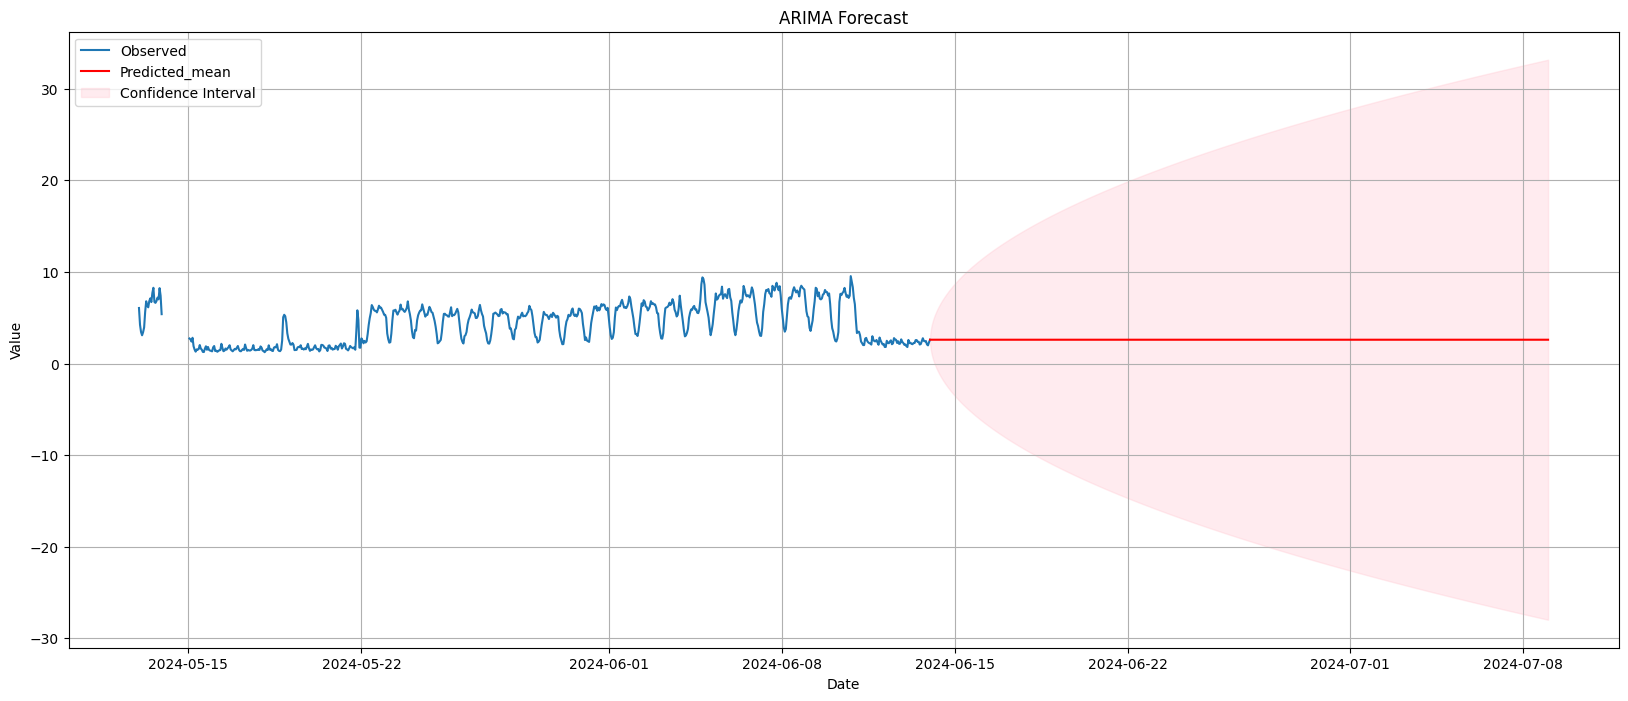

In [14]:
plt.figure(figsize=(20, 8))
df_hourly_data = df.resample('h').mean()
plt.plot(df_hourly_data, label='Observed')  # Plot observed data
plt.plot(forecast_df['predicted_mean'], color='r', label='Predicted_mean')  # Plot forecasted values
plt.fill_between(forecast_df.index, forecast_df['lower_ci'], forecast_df['upper_ci'], color='pink', alpha=0.3, label='Confidence Interval')  # Plot confidence interval
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

<Axes: xlabel='date'>

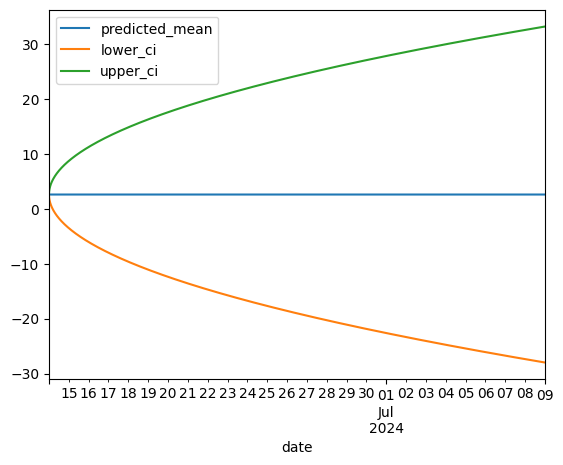

In [15]:
forecast_df.plot()

In [16]:
print(df)
prediction = model_fit.predict('2024-05-13 00:00:00', '2024-06-13 00:00:00')
prediction_df = pd.DataFrame(prediction)
prediction_df.to_csv('../data/predicted/arima_month_prediction_nodeload15.csv', index=True)
print(prediction_df)

                        y
ds                       
2024-05-13 00:00:00  6.53
2024-05-13 00:00:05  6.53
2024-05-13 00:00:10  6.53
2024-05-13 00:00:15  6.52
2024-05-13 00:00:20  6.52
...                   ...
2024-06-13 23:59:40  2.60
2024-06-13 23:59:45  2.60
2024-06-13 23:59:50  2.60
2024-06-13 23:59:55  2.60
2024-06-14 00:00:00  2.60

[532711 rows x 1 columns]
                     predicted_mean
ds                                 
2024-05-13 00:00:00            0.00
2024-05-13 00:00:05            6.53
2024-05-13 00:00:10            6.53
2024-05-13 00:00:15            6.53
2024-05-13 00:00:20            6.52
...                             ...
2024-06-12 23:59:40            2.03
2024-06-12 23:59:45            2.03
2024-06-12 23:59:50            2.02
2024-06-12 23:59:55            2.02
2024-06-13 00:00:00            2.02

[515430 rows x 1 columns]


In [17]:
print(df.describe())
print(prediction_df.describe())

                   y
count  532711.000000
mean        4.380956
std         2.186642
min         1.090000
25%         2.230000
50%         4.730000
75%         6.060000
max        10.500000
       predicted_mean
count   515430.000000
mean         4.451536
std          2.187526
min          0.000000
25%          2.270000
50%          4.920000
75%          6.110000
max         10.500002


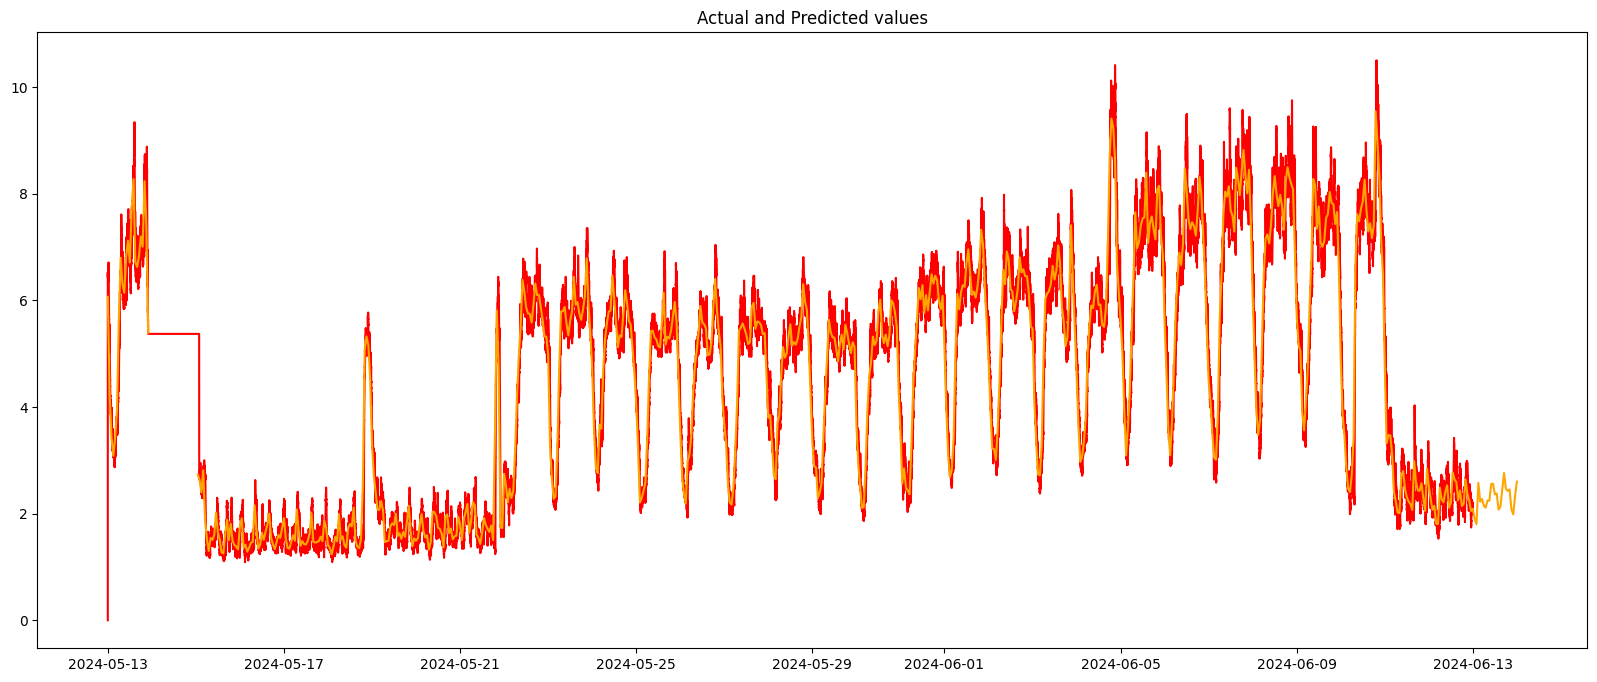

In [18]:
plt.figure(figsize=(20, 8))
#df_hourly_data = df.resample('h').mean()
plt.plot(prediction_df['predicted_mean'], color='red',label='predicted')
plt.plot(df_hourly_data.y, color='orange', label="y")
plt.title('Actual and Predicted values')
plt.show()

NameError: name 'predictions_df' is not defined

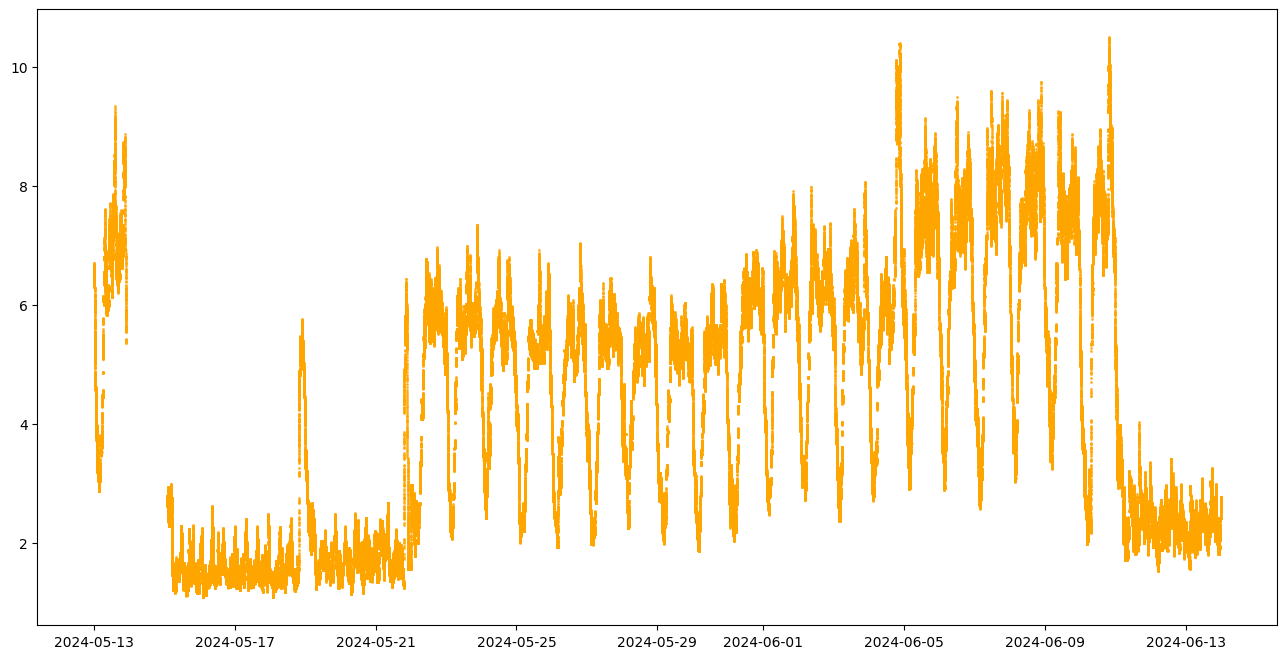

In [19]:
plt.figure(figsize = (16,8))
plt.scatter(df.index, df['y'], color='orange', alpha=0.5, s =1)
plt.scatter(predictions_df.index, predictions_df['predicted_mean'], color='red', alpha=0.5, s =1)
#plt.plot(forecast_df['predicted_mean'], color='r', label='Predicted_mean')

In [ ]:
plt.figure(figsize = (16,8))
plt.scatter(predictions_df.index[:100000], predictions_df['predicted_mean'].head(100000), color='red', alpha=0.5, s =1)
plt.scatter(df.index[:100000], df['y'].head(100000), color='orange', alpha=0.5, s =1)
#plt.plot(forecast_df['predicted_mean'], color='r', label='Predicted_mean')

In [ ]:
predictions_df
def plot(df,df1):
    plt.figure(figsize=(15,5))
    plt.plot(df)
    plt.plot(df1)
    plt.legend(('data', 'predictions'), fontsize=10)
    plt.title("", fontsize=20)
    plt.ylabel('nodeload15', fontsize= 16)
    plt.axhline(0, color= 'r', linestyle= '--', alpha= 0.2)
        
plot(df['y'], predictions_df['predicted_mean'])

In [ ]:
df_hourly_data = df.resample('H').mean()
predictions_df_hourly_data = predictions_df.resample('H').mean()
plt.figure(figsize=(12, 6))
plt.plot(hourly_data.index, hourly_data['y'], marker='o', linestyle='-', color='b', label='Hourly Data')
plt.plot(predictions_df_hourly_data.index, predictions_df_hourly_data['predicted_mean'], marker='o', linestyle='-', color='yellow', label='Hourly Data')
plt.title('Hourly Aggregated Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()